<a href="https://colab.research.google.com/github/cindyhfls/NMA_DL_2021_project/blob/main/DifferentRegionsCorrelatedLatents/s31_TH_MO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focus on what matters: inferring low-dimensional dynamics from neural recordings

**By Neuromatch Academy**

__Content creators:__ Marius Pachitariu, Pedram Mouseli, Lucas Tavares, Jonny Coutinho, 
Blessing Itoro, Gaurang Mahajan, Rishika Mohanta

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective: 
It is very difficult to interpret the activity of single neurons in the brain, because their firing patterns are noisy, and it is not clear how a single neuron can contribute to cognition and behavior. However, neurons in the brain participate in local, regional and brainwide dynamics. No neuron is isolated from these dynamics, and much of a single neuron's activity can be predicted from the dynamics. Furthermore, only populations of neurons as a whole can control cognition and behavior. Hence it is crucial to identify these dynamical patterns and relate them to stimuli or behaviors. 

In this notebook, we generate simulated data from a low-dimensional dynamical system and then use seq-to-seq methods to predict one subset of neurons from another. This allows us to identify the low-dimensional dynamics that are sufficient to explain the activity of neurons in the simulation. The methods described in this notebook can be applied to large-scale neural recordings of hundreds to tens of thousans of neurons, such as the ones from the NMA-CN course.

---
# Setup

In [63]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math
from sklearn.linear_model import LinearRegression


import copy

In [64]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [66]:
def pearson_corr_tensor(input, output):
  rpred = output.detach().cpu().numpy()
  rreal = input.detach().cpu().numpy()
  rpred_flat = np.ndarray.flatten(rpred)
  rreal_flat = np.ndarray.flatten(rreal)
  corrcoeff = np.corrcoef(rpred_flat, rreal_flat)
  return corrcoeff[0,1]

In [67]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

**Note:** If `cuda` is not enabled, go to `Runtime`--> `Change runtime type` and in `Hardware acceleration` choose `GPU`. 

In [68]:
# Data Loading

#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [69]:
#@title Print Keys
print(alldat[0].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [70]:
#@title Define Steinmetz Class
class SteinmetzSession:
  data = []
  binSize = 10
  nTrials = []
  nNeurons = []
  trialLen = 0
  trimStart = "trialStart"
  trimEnd =  "trialEnd"
  def __init__(self, dataIn):
    self.data = copy.deepcopy(dataIn)
    dims1 = np.shape(dataIn['spks'])
    self.nTrials = dims1[1]
    self.nNeurons = dims1[0]
    self.trialLen = dims1[2]

  def binData(self, binSizeIn): # Inputs: data, scalar for binning. Combines binSizeIn bins together to bin data smaller Ex. binSizeIn of 5 on the original dataset combines every 5 10 ms bins into one 50 ms bin across all trials.
    varsToRebinSum = ['spks']
    varsToRebinMean = ['wheel', 'pupil']
    spikes = self.data['spks']
    histVec = range(0,self.trialLen+1, binSizeIn)
    spikesBin = np.zeros((self.nNeurons, self.nTrials, len(histVec)))
    print(histVec)
    for trial in range(self.nTrials):
      spikes1 = np.squeeze(spikes[:,trial,:])
      for time1 in range(len(histVec)-1):
        spikesBin[:,trial, time1] = np.sum(spikes1[:, histVec[time1]:histVec[time1+1]-1], axis=1)

    spikesBin = spikesBin[:,:,:-1]
    self.data['spks'] = spikesBin
    self.trialLen = len(histVec) -1
    self.binSize = self.binSize*binSizeIn

    
    s = "Binned spikes, turning a " + repr(np.shape(spikes)) + " matrix into a " + repr(np.shape(spikesBin)) + " matrix"
    print(s)

  def plotTrial(self, trialNum): # Basic function to plot the firing rate during a single trial. Used for debugging trimming and binning
    plt.imshow(np.squeeze(self.data['spks'][:,trialNum,:]), cmap='gray_r', aspect = 'auto')
    plt.colorbar()
    plt.xlabel("Time (bins)")
    plt.ylabel("Neuron #")
    
  def realign_data_to_movement(self,length_time_in_ms): # input has to be n * nTrials * nbins
    align_time_in_bins = np.round(self.data['response_time']/self.binSize*1000)+ int(500/self.binSize) # has to add 0.5 s because the first 0.5 s is pre-stimulus
    length_time_in_bins = int(length_time_in_ms/self.binSize)
    validtrials = self.data['response']!=0
    maxtime = self.trialLen
    newshape = (self.nNeurons,self.nTrials)
    newshape+=(length_time_in_bins,)
    newdata = np.empty(newshape)
    for count,align_time_curr_trial in enumerate(align_time_in_bins):
      if (validtrials[count]==0)|(align_time_curr_trial+length_time_in_bins>maxtime) :
        validtrials[count] = 0
      else:
        newdata[:,count,:]= self.data['spks'][:,count,int(align_time_curr_trial):int(align_time_curr_trial)+length_time_in_bins]
    # newdata = newdata[:,validtrials,:]
    self.data['spks'] = newdata
    # self.validtrials = validtrials
    print('spikes aligned to movement, returning validtrials')
    return validtrials
  
  def get_areas(self):
    print(set(list(self.data['brain_area'])))

  def extractROI(self, region): #### extract neurons from single region
    rmrt=list(np.where(self.data['brain_area']!=region))[0]
    print(f' removing data from {len(rmrt)} neurons not contained in {region} ')
    self.data['spks']=np.delete(self.data['spks'],rmrt,axis=0)
    neur=len(self.data['spks'])
    print(f'neurons remaining in trial {neur}')
    self.data['brain_area']=np.delete(self.data['brain_area'],rmrt,axis=0)
    self.data['ccf']=np.delete(self.data['ccf'],rmrt,axis=0)
    
  def FlattenTs(self):
    self.data['spks']=np.hstack(self.data['spks'][:])

  def removeTrialAvgFR(self):
    mFR = self.data['spks'].mean(1)
    mFR = np.expand_dims(mFR, 1).repeat(self.data['spks'].shape[1],axis = 1)
    print(np.shape(self.data['spks']))
    print(np.shape(mFR))
    self.data['spks'] = self.data['spks'].astype(float)
    self.data['spks'] -= mFR
  def permdims(self):
    return torch.permute(torch.tensor(self.data['spks']),(2,1,0))

  def smoothFR(self, smoothingWidth):# TODO: Smooth the data and save it back to the data structure
    return 0


# select session and area

In [87]:
# set the sessions
session_num = 30
curr_session=SteinmetzSession(alldat[session_num])
# some preprocessing
validtrials = curr_session.realign_data_to_movement(500) # get 500 ms from movement time, 
# cannot get realign and binning to work the same time =[
  # print areas
curr_session.get_areas()


spikes aligned to movement, returning validtrials
{'CA3', 'SNr', 'SCm', 'OLF', 'POST', 'ORB', 'TH', 'MOs'}


In [88]:
# CHANGE ME

# set areas
PA_name = 'MOs' # predicted area
IA_name = 'TH' # input area

# Set input/hyperparameters here:
ncomp = 10
learning_rate_start = 0.005

 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281
torch.Size([50, 158, 281])
 removing data from 868 neurons not contained in TH 
neurons remaining in trial 109
torch.Size([50, 158, 109])


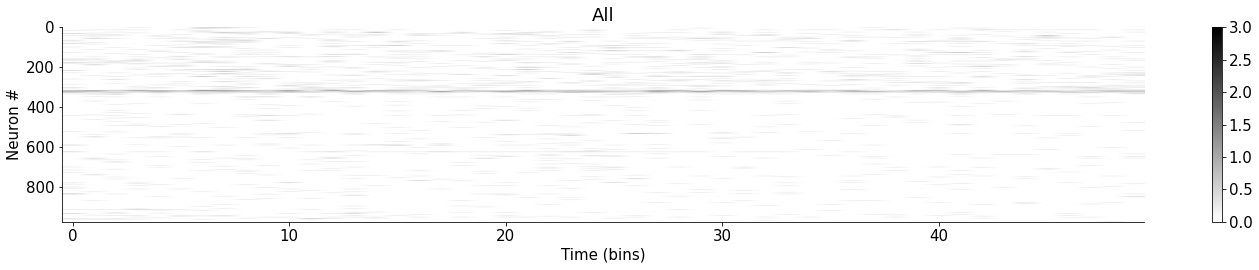

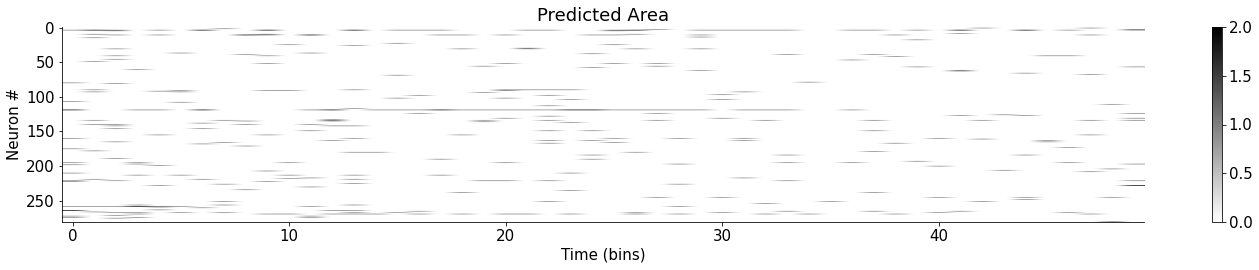

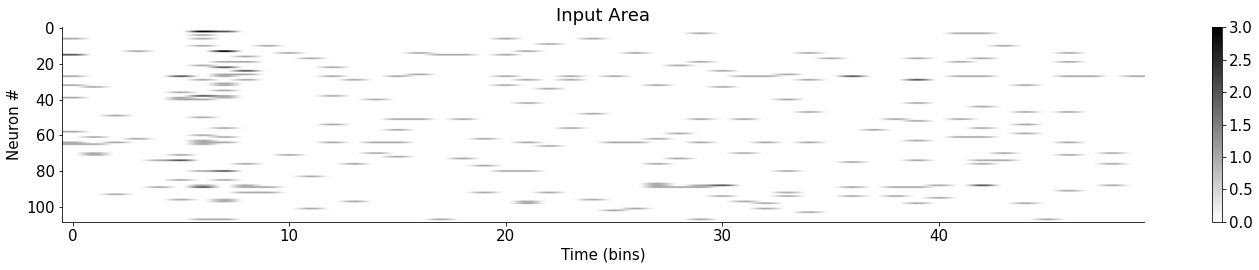

In [89]:
nTr = np.argwhere(validtrials) # since the other trials were defaulted to a zero value, only plot the valid trials

## plot a trial
plt.figure()
curr_session.plotTrial(nTr[1])
plt.title('All')

PA = copy.deepcopy(curr_session)
###remove all neurons not in motor cortex
PA.extractROI(PA_name)
### plot a trial from motor neuron
plt.figure()
PA.plotTrial(nTr[1])
plt.title('Predicted Area')
### permute the trials
PAdata = PA.permdims().float().to(device)
PAdata = PAdata[:,validtrials,:]
print(PAdata.shape)

if IA_name == 'noise':
  # generate some negative controls:
  neg_control_randn,_ = torch.max(torch.randn(PAdata.shape),0) # for now say the shape of noise matches the predicted area, I doubt that matters?
  plt.imshow(neg_control_randn.numpy(),cmap = 'gray_r',aspect = 'auto')
  plt.title('Random noise')
else:
  IA = copy.deepcopy(curr_session)
  ###remove all neurons not in motor cortex
  IA.extractROI(IA_name)
  ### plot a trial from motor neuron
  plt.figure()
  IA.plotTrial(nTr[1])
  plt.title('Input Area')
  IAdata = IA.permdims().float().to(device)
  IAdata = IAdata[:,validtrials,:]
  print(IAdata.shape)

In [90]:
#@title get indices for trials (split into ~60%, 30%,10%)
N = PAdata.shape[1]
np.random.seed(42)
ii = torch.randperm(N).tolist()
idx_train = ii[:math.floor(0.6*N)]
idx_val = ii[math.floor(0.6*N):math.floor(0.9*N)]
idx_test = ii[math.floor(0.9*N):]

In [91]:
#@title split into train, test and validation set
x0 = IAdata
x0_train = IAdata[:,idx_train,:]
x0_val = IAdata[:,idx_val,:]
x0_test = IAdata[:,idx_test,:]

x1 = PAdata
x1_train = PAdata[:,idx_train,:]
x1_val = PAdata[:,idx_val,:]
x1_test = PAdata[:,idx_test,:]

NN1 = PAdata.shape[2]
NN2 = IAdata.shape[2]

#Our RNN model

In [92]:
class Net_singleinput(nn.Module): # our model
  def __init__(self, ncomp, NN2, NN1, bidi=True): # NN2 is input dim, NN1 is output dim
    super(Net_singleinput, self).__init__()

    # play with some of the options in the RNN!
    self.rnn1 = nn.RNN(NN2, ncomp, num_layers = 1, dropout = 0, # PA
                      bidirectional = bidi, nonlinearity = 'tanh')

    self.fc = nn.Linear(ncomp,NN1)

  def forward(self, x0,x1):
    y =  self.rnn1(x0)[0] # ncomp IAs

    if self.rnn1.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)
 
    return z, q

# train model


In [93]:
# @title train loop
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

def train(net,train_input,train_output,val_input,val_output,niter = 400):
  set_seed(42)
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate_start)
  training_cost = []
  val_cost = []
  for k in range(niter):
    ### training
    optimizer.zero_grad()
    # the network outputs the single-neuron prediction and the latents
    z,_= net(train_input,train_output)
    # our log-likelihood cost
    cost = Poisson_loss(z, train_output).mean()
    # train the network as usual
    cost.backward()
    optimizer.step()
    training_cost.append(cost.item())

    ### test on validation data
    z_val,_ = net(val_input,val_output)
    cost = Poisson_loss(z_val, val_output).mean()
    val_cost.append(cost.item())

    if k % 100 == 0:
      print(f'iteration {k}, cost {cost.item():.4f}')
    
  return training_cost,val_cost

In [94]:
# @title train model PA->PA only
net_PAPA = Net_singleinput(ncomp, NN1, NN1, bidi = False).to(device)
net_PAPA.fc.bias.data[:] = x1.mean((0,1))

training_cost_PAPA,val_cost_PAPA = train(net_PAPA,x1_train,x1_train,x1_val,x1_val) # train

Random seed 42 has been set.
iteration 0, cost 0.1734
iteration 100, cost 0.0648
iteration 200, cost 0.0618
iteration 300, cost 0.0608


In [95]:
# @title train model IA->PA only
net_IAPA = Net_singleinput(ncomp, NN2, NN1, bidi = False).to(device)
net_IAPA.fc.bias.data[:] = x1.mean((0,1))

training_cost_IAPA,val_cost_IAPA = train(net_IAPA,x0_train,x1_train,x0_val,x1_val) # train

Random seed 42 has been set.
iteration 0, cost 0.1714
iteration 100, cost 0.0812
iteration 200, cost 0.0786
iteration 300, cost 0.0791


# Some plots and analyses

Text(0.5, 0, 'epochs')

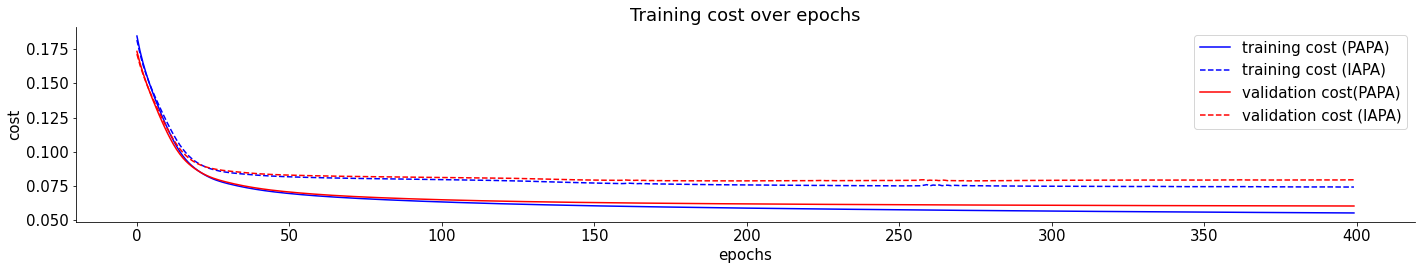

In [96]:
#@title plot the training side-by-side
plt.plot(training_cost_PAPA,'b')
plt.plot(training_cost_IAPA,'b',linestyle = '--')

plt.plot(val_cost_PAPA,'r')
plt.plot(val_cost_IAPA,'r',linestyle = '--')

plt.legend(['training cost (PAPA)','training cost (IAPA)','validation cost(PAPA)',
            'validation cost (IAPA)'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')


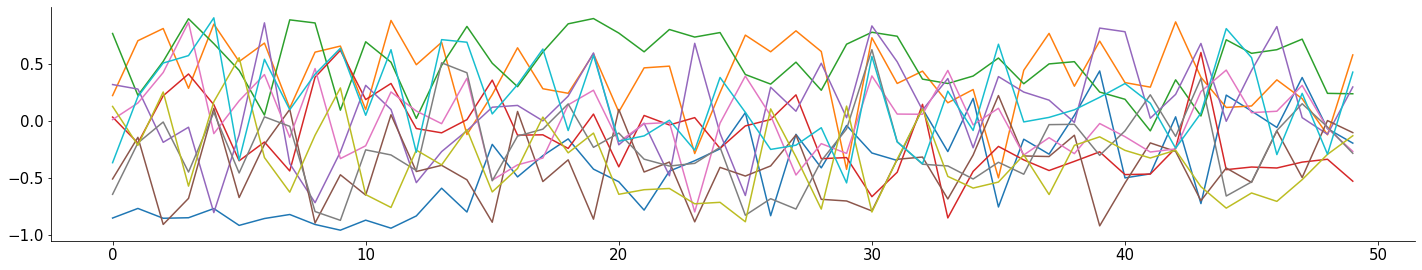

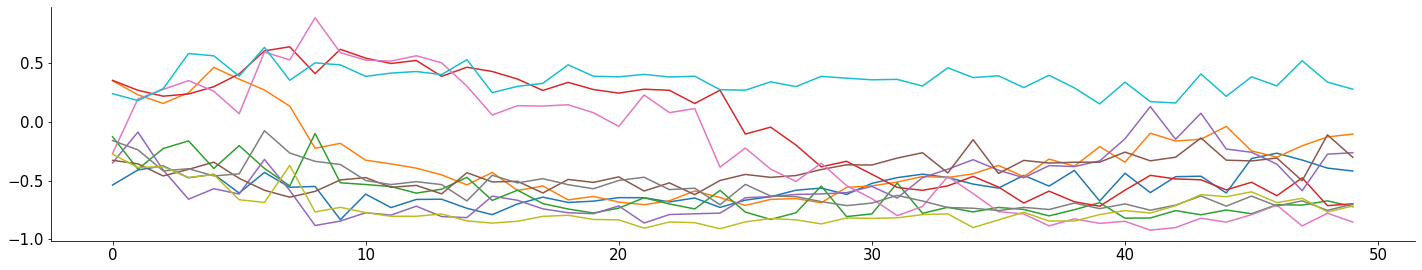

In [97]:
# see if the latents are correlated?
z_PAPA,y_PAPA= net_PAPA(x1_train,x1_train)
plt.figure()
plt.plot(y_PAPA[:,0,:].detach().cpu().numpy())

z_IAPA,y_IAPA= net_IAPA(x0_train,x1_train)
plt.figure()
plt.plot(y_IAPA[:,0,:].detach().cpu().numpy())

In [98]:
print(F.cosine_similarity(z_PAPA.flatten(start_dim = 0,end_dim = 1).T,z_IAPA.flatten(start_dim = 0,end_dim = 1).T).mean())
print(F.cosine_similarity(z_PAPA.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).mean())
print(F.cosine_similarity(z_IAPA.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).mean())


tensor(0.3525, grad_fn=<MeanBackward0>)
tensor(0.3279, grad_fn=<MeanBackward0>)
tensor(0.1504, grad_fn=<MeanBackward0>)


Text(0.5, 1.0, 'cosine_similarity by neuron')

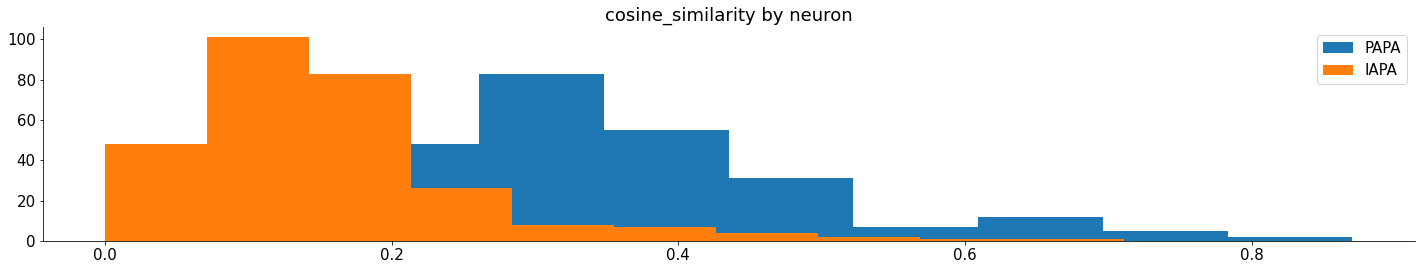

In [99]:
plt.hist(F.cosine_similarity(z_PAPA.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).detach().cpu().numpy())
plt.hist(F.cosine_similarity(z_IAPA.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).detach().cpu().numpy())
plt.legend(('PAPA','IAPA'))
plt.title('cosine_similarity by neuron')

In [100]:
def regress_tensor(X,y):
  X = X.detach().cpu().numpy()
  y = y.flatten().detach().cpu().numpy().reshape(-1,1)
  # print(X.shape)
  # print(y.shape)
  model = LinearRegression()
  model.fit(X, y)
  r_sq = model.score(X, y)
  print('coefficient of determination:', r_sq)
  return r_sq

In [101]:
rsqmat = []
for i in range(ncomp):
  rsqmat.append(regress_tensor(y_IAPA.flatten(start_dim = 0,end_dim = 1),y_PAPA[:,:,i].reshape(-1,1)))

coefficient of determination: 0.2360189196685274
coefficient of determination: 0.08604820083319942
coefficient of determination: 0.23511817638466015
coefficient of determination: 0.14229090171666647
coefficient of determination: 0.2720750177783219
coefficient of determination: 0.10743137008097436
coefficient of determination: 0.22399054964802845
coefficient of determination: 0.024698375617431045
coefficient of determination: 0.2320936359044223
coefficient of determination: 0.2137453670428945


In [102]:
Avg_rsq = sum(rsqmat)/len(rsqmat)
print('Average Rsq for predicting the %i latents in IAPA from a linear combination of %i latents in PAPA is %2.3f'%(ncomp,ncomp,Avg_rsq))
max_rsq = max(rsqmat)
print('Max Rsq for predicting the %i latents in IAPA from a linear combination of %i latents in PAPA is %2.3f'%(ncomp,ncomp,max_rsq))

Average Rsq for predicting the 10 latents in IAPA from a linear combination of 10 latents in PAPA is 0.177
Max Rsq for predicting the 10 latents in IAPA from a linear combination of 10 latents in PAPA is 0.272
